In [1]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from PIL import Image 
from torch.utils.data import DataLoader
import seaborn as sns

import numpy as np

import matplotlib.pyplot as plt #
import cv2
import os
import pandas as pd
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

(380, 210, 3)


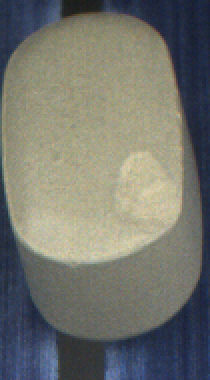

In [3]:
image  = Image.open('images/001.bmp')
print(np.array(image, dtype =float).shape)
image

# Create the dataloader

In [4]:
class CustomImageDataset(Dataset):
    def __init__( self, annotations_file, img_dir ):
        self.annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
        image  = Image.open(img_path)
        image = np.array(image, dtype =float)
        image = image.T
        
        image = torch.from_numpy(image)
        label = torch.tensor(int(self.annotations.iloc[idx, 1]))
                   
        return (image, label)

IMPORTANT : The labels.csv file must look like: 

001.bmp, 8

002.bmp, 0

......

200.bmp, 9

In [5]:
data_set = CustomImageDataset( 'labels.csv', 'images/')

In [6]:
data_set

In [7]:
data_set[0]  #tuple (tenseur image, tenseur entier)

(tensor([[[ 43.,  43.,  37.,  ...,  70.,  51.,  51.],
          [ 43.,  43.,  37.,  ...,  70.,  51.,  51.],
          [ 41.,  41.,  37.,  ...,  46.,  47.,  47.],
          ...,
          [ 35.,  35.,  30.,  ...,  51.,  40.,  40.],
          [ 30.,  30.,  33.,  ...,  43.,  40.,  40.],
          [ 30.,  30.,  33.,  ...,  43.,  40.,  40.]],
 
         [[ 56.,  56.,  51.,  ...,  73.,  71.,  71.],
          [ 56.,  56.,  51.,  ...,  73.,  71.,  71.],
          [ 50.,  50.,  51.,  ...,  61.,  65.,  65.],
          ...,
          [ 38.,  38.,  37.,  ...,  60.,  54.,  54.],
          [ 35.,  35.,  33.,  ...,  58.,  57.,  57.],
          [ 35.,  35.,  33.,  ...,  58.,  57.,  57.]],
 
         [[ 71.,  71.,  66.,  ..., 108., 108., 108.],
          [ 71.,  71.,  66.,  ..., 108., 108., 108.],
          [ 66.,  66.,  71.,  ...,  88.,  98.,  98.],
          ...,
          [ 59.,  59.,  52.,  ...,  81.,  92.,  92.],
          [ 51.,  51.,  57.,  ..., 104., 103., 103.],
          [ 51.,  51.,  57.,  .

In [8]:
train_set, test_set = torch.utils.data.random_split(data_set, [6, 4])

In [9]:
train_set

In [10]:
batch_size = 2

train_loader = DataLoader(dataset=train_set, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size = batch_size, shuffle=True)

In [11]:
train_loader

# Create a model and train it

In [12]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

num_classes = 10
learning_rate = 1e-3
num_epochs = 10


cpu


In [13]:
# Model
model = torchvision.models.vgg16(pretrained=True)


# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    

model.to(device)
model = model

# Add on classifier
num_features = model.classifier[6].in_features #4096
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, num_classes)]) # Add our layer with 10 outputs
features.extend([nn.Softmax(dim=1)])
model.classifier = nn.Sequential(*features)

In [14]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
# Train Network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in enumerate(train_loader):
        
               
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        
        # forward
        scores = model(data.float())
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        
    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")


C:\Users\pierr\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Cost at epoch 0 is 2.3307077884674072
Cost at epoch 1 is 2.3994925816853843
Cost at epoch 2 is 2.3541348775227866
Cost at epoch 3 is 2.289255420366923
Cost at epoch 4 is 2.2944814364115396
Cost at epoch 5 is 2.2944807211558023
Cost at epoch 6 is 2.29448131720225
Cost at epoch 7 is 2.2944792906443277
Cost at epoch 8 is 2.2944839795430503
Cost at epoch 9 is 2.2943814595540366


# Evaluation

In [17]:
# Check accuracy on training to see how good our model is
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x.float())
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

    model.train()


print("Checking accuracy on Training Set")
check_accuracy(train_loader, model)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, model)

Checking accuracy on Training Set
Got 1 / 6 with accuracy 16.67
Checking accuracy on Test Set
Got 1 / 4 with accuracy 25.00


In [18]:
nb_classes = 10

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs.float())
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)




tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])


In [19]:
plt.figure(figsize=(15,10))

class_names = ['good', 'edge', 'logo', 'vrac', 'defect', 'chip', 'f', 'g', 'h', 'i']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)


<Figure size 1080x720 with 0 Axes>

In [1]:
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

NameError: name 'sns' is not defined

# Brouillons : ne pas lire

In [ ]:
A voir :
score F1 multiclasses
voire Fbeta

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

labels = ...
predictions = ...

cm = confusion_matrix(labels, predictions)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

In [ ]:
np.mean(recall)
np.mean(precision)

In [ ]:
#from torch.torchmetrics import F1

#f1 = F1(num_classes=3)
#f1(preds, target)

for  (inputs, classes) in (test_loader):
    print(inputs)

In [ ]:
import numpy 
a3D = numpy.array([[[1, 2], [3, 4]],[[5, 6], [7, 8]]])

type(a3D)

In [ ]:
a= pd.read_csv('labels.csv')
a

